In [2]:
import sys
import os
if '__file__' in locals():
    current_script_dir = os.path.dirname(os.path.abspath(__file__))
else:
    current_script_dir = os.getcwd() 
project_root = os.path.abspath(os.path.join(current_script_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from scripts.core_imports import *

# Plotting Predicted Livestock Population:

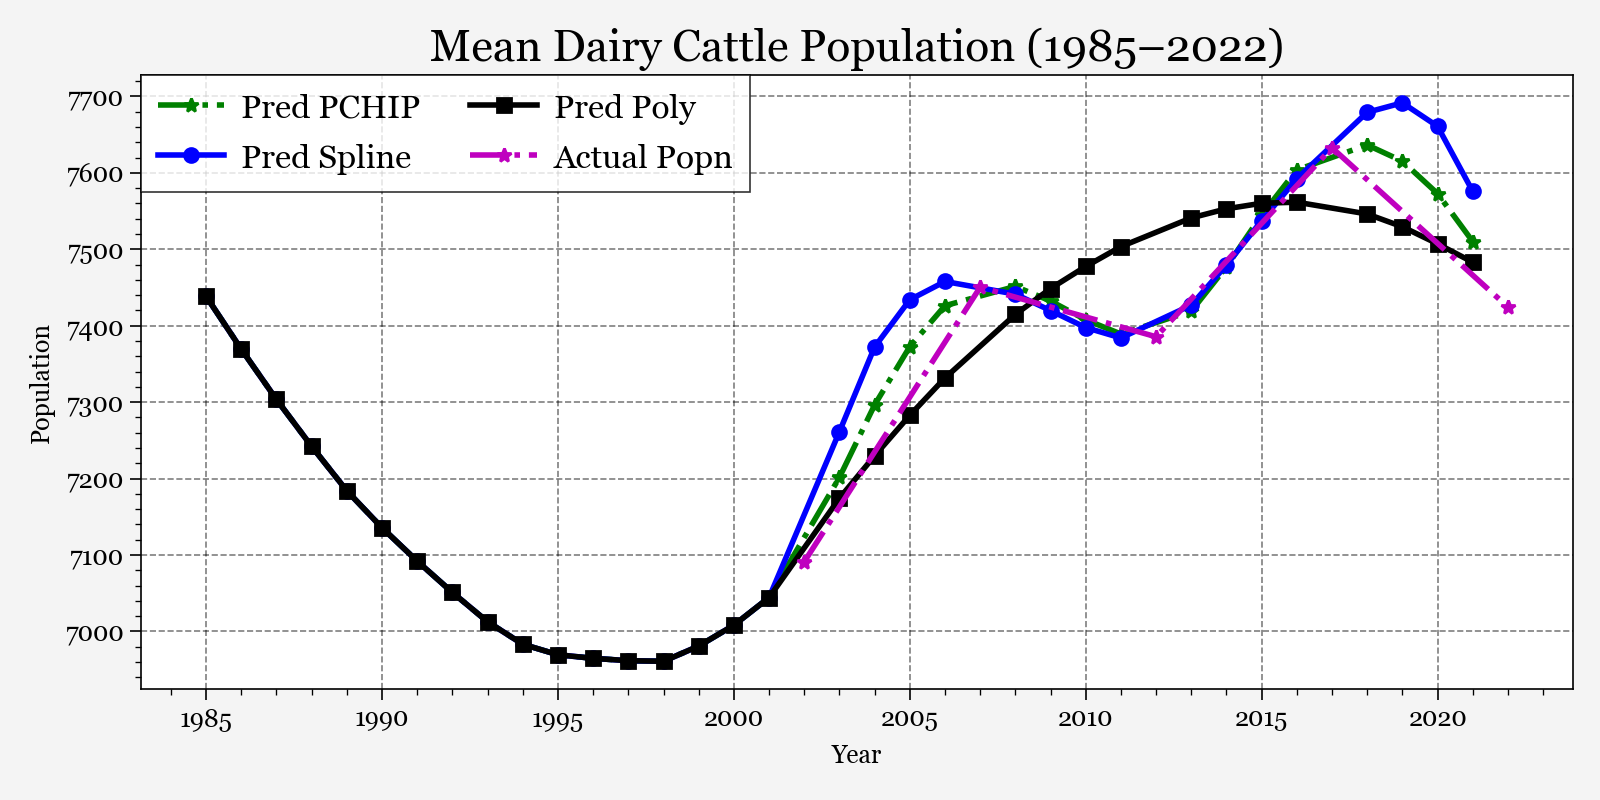

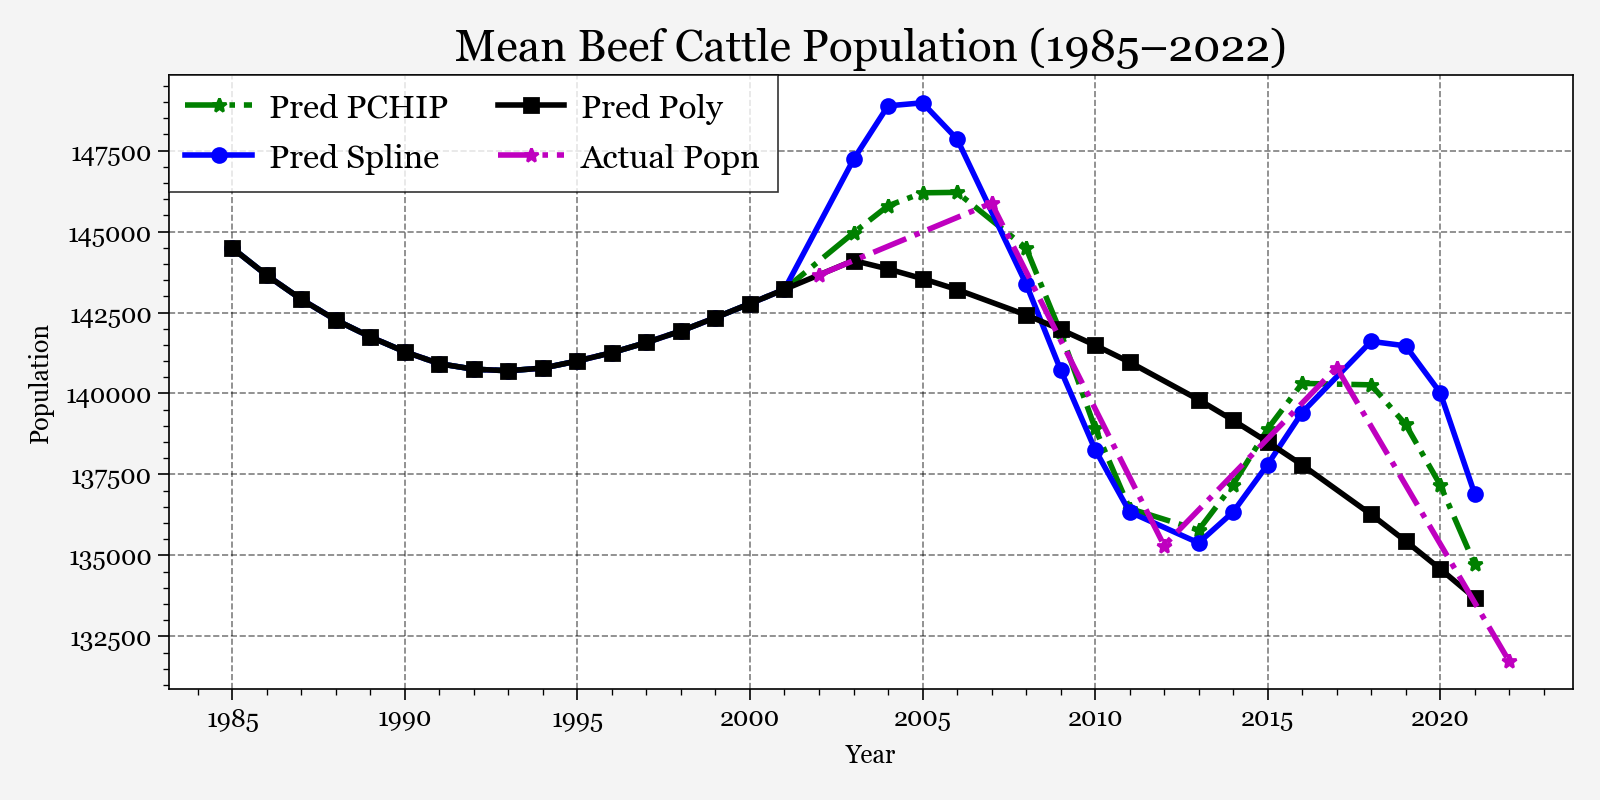

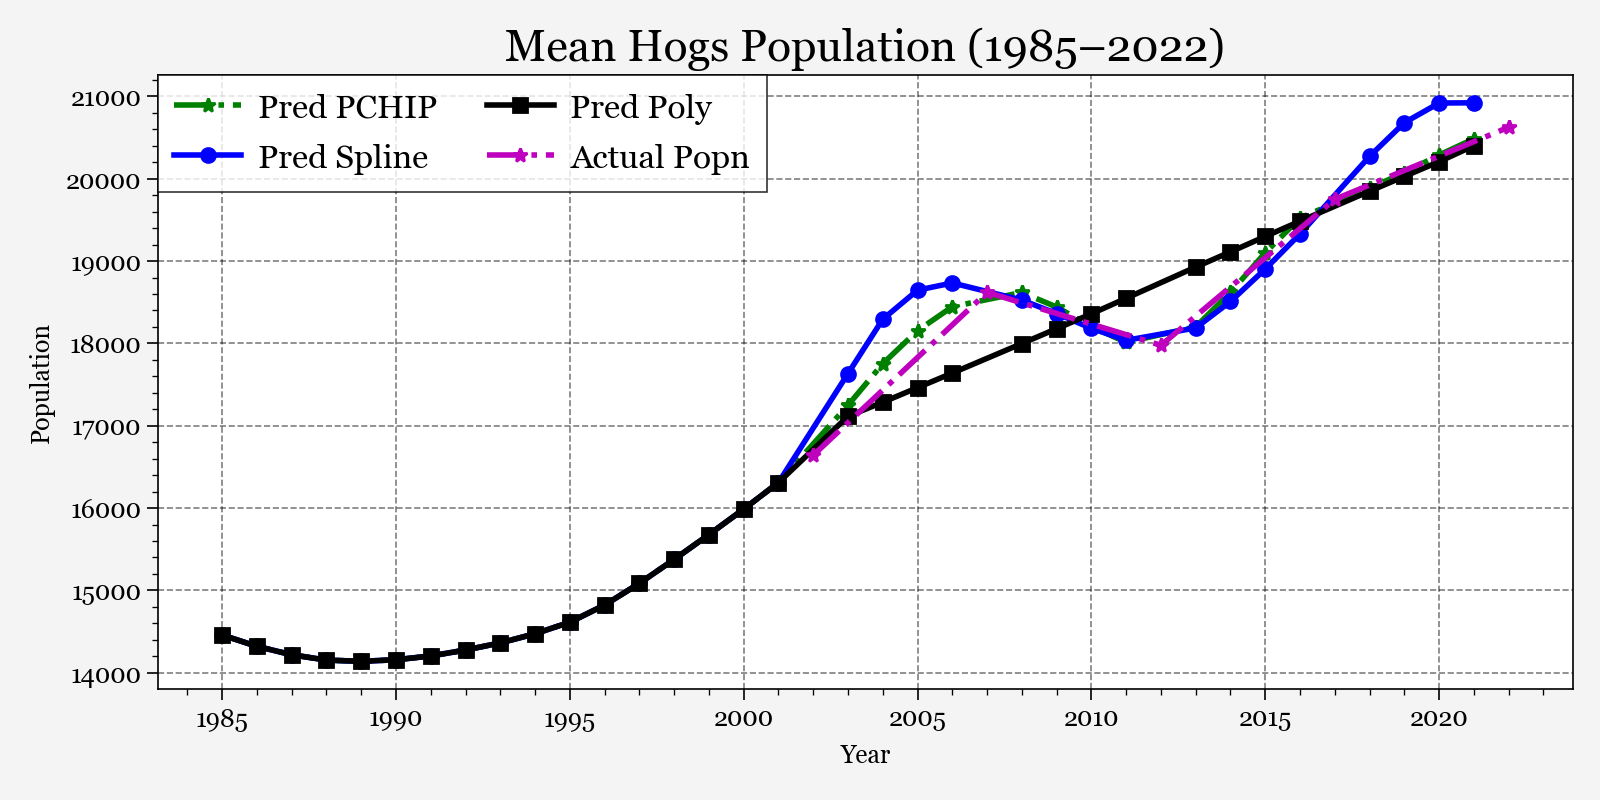

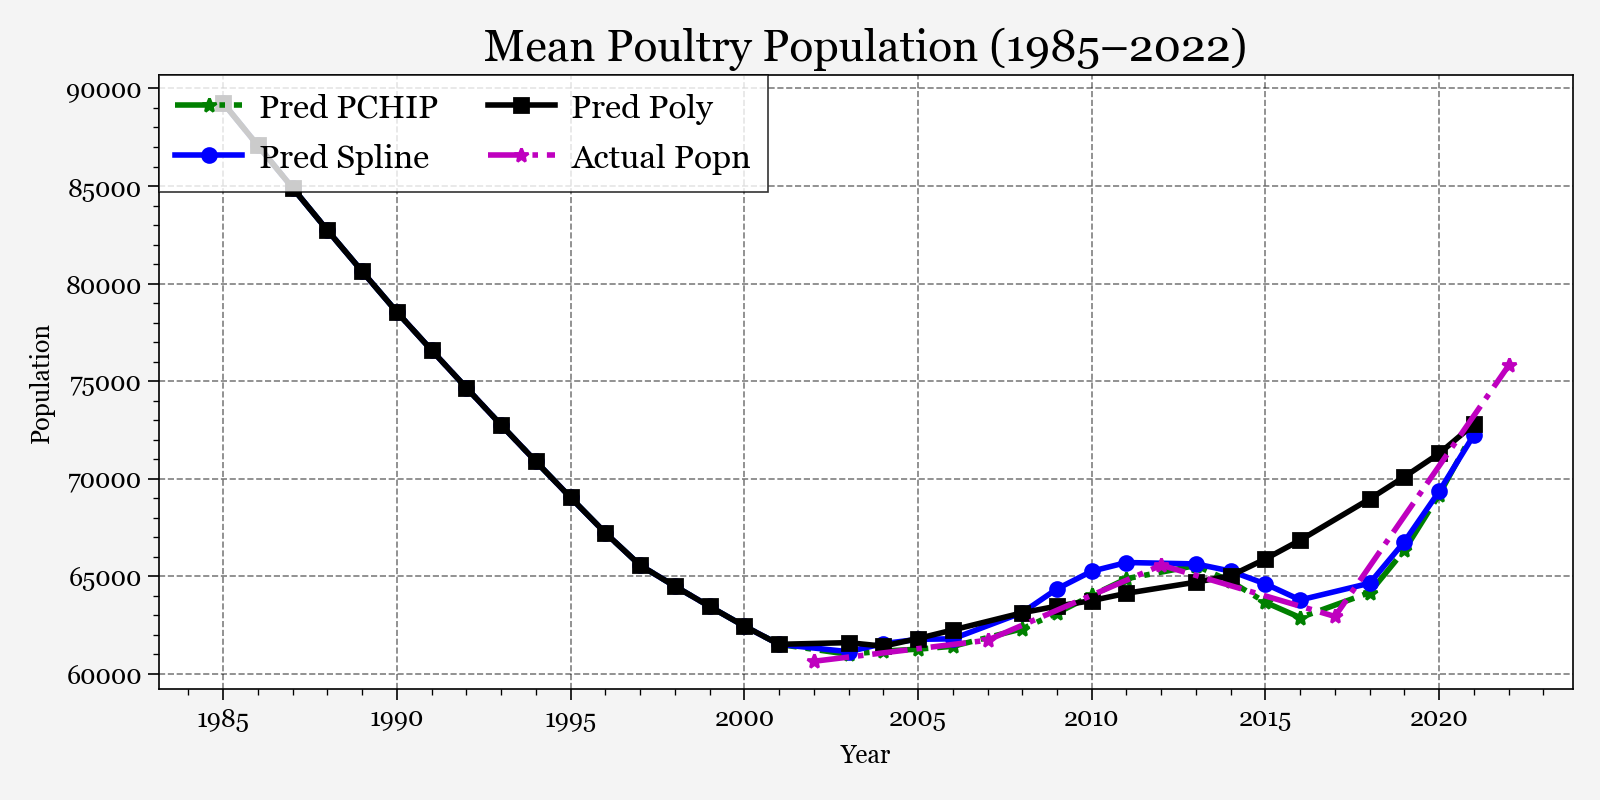

In [75]:

data_dir = r"C:\Users\hdagne1\Box\Dr.Mesfin Research\Codes\HighRes_County_level_LivestockWaterUse_CONUS_dataset\data\proccessed_data\livestock_census"
livestock_types = ['Dairy_Cattle', 'Beef_Cattle', 'Hogs', 'Poultry']
methods = ['PCHIP', 'Spline', 'Polynomial']

# Load all datasets into a nested dictionary
livestock_dfs = {
    animal.replace('_', ' '): {
        method: pd.read_feather(os.path.join(data_dir, f"Interpolated_{animal}_{method}_1985_2022.feather"))
        for method in methods
    }
    for animal in livestock_types
}
actual_years = [2002, 2007, 2012, 2017, 2022]

for animal, dfs in livestock_dfs.items():
    all_years = dfs['PCHIP'].columns.astype(int)
    predicted_years = [y for y in all_years if y not in actual_years]
    
    mean_values = {method: df.mean(axis=0) for method, df in dfs.items()}

    predicted = {method: vals.loc[predicted_years] for method, vals in mean_values.items()}
    actual = mean_values['PCHIP'].loc[actual_years]
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(predicted_years, predicted['PCHIP'], label='Pred PCHIP', color='green', lw=2, linestyle='-.', marker='*', markersize=5)
    plt.plot(predicted_years, predicted['Spline'], label='Pred Spline', color='b', lw=2, marker='o', markersize=5)
    plt.plot(predicted_years, predicted['Polynomial'], label='Pred Poly', color='black', lw=2, marker='s', markersize=5)
    plt.plot(actual_years, actual, label='Actual Popn', color='m', lw=2, marker='*', linestyle='-.', markersize=5)
    
    plt.title(f'Mean {animal} Population (1985–2022)', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.legend(fontsize=12, loc='upper left', ncol=2)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Call CL WC and CL WW:

In [248]:

shapefile_path = r'C:\Users\hdagne1\Box\Dr.Mesfin Research\Data\CONUS_geometries\CONUS_Counties\CONUS_Counties.shp'
CONUS_counties = gpd.read_file(shapefile_path)
CONUS_counties.rename(columns={'NAME': 'COUNTY_NAME'}, inplace=True)
CONUS_counties['COUNTY_NAME'] = CONUS_counties['COUNTY_NAME'].str.upper()
CONUS_counties['STATE_NAME']  = CONUS_counties['STATE_NAME'].str.upper()
CONUS_counties['COUNTY_NAME'] = CONUS_counties['COUNTY_NAME'].str.replace(' COUNTY', '').str.upper()

# Dictionary mapping USPS codes to full state names
us_state_abbrev_to_name = {
    'AL':'ALABAMA','AK':'ALASKA','AZ':'ARIZONA','AR':'ARKANSAS','CA':'CALIFORNIA',
    'CO':'COLORADO','CT':'CONNECTICUT','DE':'DELAWARE','FL':'FLORIDA','GA':'GEORGIA',
    'HI':'HAWAII','ID':'IDAHO','IL':'ILLINOIS','IN':'INDIANA','IA':'IOWA','KS':'KANSAS',
    'KY':'KENTUCKY','LA':'LOUISIANA','ME':'MAINE','MD':'MARYLAND','MA':'MASSACHUSETTS',
    'MI':'MICHIGAN','MN':'MINNESOTA','MS':'MISSISSIPPI','MO':'MISSOURI','MT':'MONTANA',
    'NE':'NEBRASKA','NV':'NEVADA','NH':'NEW HAMPSHIRE','NJ':'NEW JERSEY','NM':'NEW MEXICO',
    'NY':'NEW YORK','NC':'NORTH CAROLINA','ND':'NORTH DAKOTA','OH':'OHIO','OK':'OKLAHOMA',
    'OR':'OREGON','PA':'PENNSYLVANIA','RI':'RHODE ISLAND','SC':'SOUTH CAROLINA','SD':'SOUTH DAKOTA',
    'TN':'TENNESSEE','TX':'TEXAS','UT':'UTAH','VT':'VERMONT','VA':'VIRGINIA','WA':'WASHINGTON',
    'WV':'WEST VIRGINIA','WI':'WISCONSIN','WY':'WYOMING','DC':'DISTRICT OF COLUMBIA','PR':'PUERTO RICO'
}


data_dir = r"C:\Users\hdagne1\Box\Dr.Mesfin Research\Codes\HighRes_County_level_LivestockWaterUse_CONUS_dataset\data\proccessed_data\usgs\usgs_water_data_feather"
output_dir = r"C:\Users\hdagne1\Box\Dr.Mesfin Research\Codes\HighRes_County_level_LivestockWaterUse_CONUS_dataset\Results"

# Load USGS data
usgs_county_cons_1985_2015 = pd.read_feather(os.path.join(data_dir, "usgs_county_cons_1985_2015.feather"))
usgs_county_cons_1985_2015['COUNTY_NAME'] = usgs_county_cons_1985_2015['COUNTY_NAME'].str.replace(' County', '', regex=False).str.upper().str.strip()
usgs_county_cons_1985_2015['State_Name'] = usgs_county_cons_1985_2015['STATE'].map(us_state_abbrev_to_name)
usgs_county_cons_1985_2015 = usgs_county_cons_1985_2015.drop(columns=['STATE'])

usgs_county_cons_1985_2015

,Year,COUNTY_NAME,CL_cons_ratio,State_Name
0,1985,AUTAUGA,0.681,ALABAMA
1,1985,BALDWIN,0.667,ALABAMA
2,1985,BARBOUR,0.600,ALABAMA
3,1985,BIBB,0.433,ALABAMA
4,1985,BLOUNT,0.984,ALABAMA
...,...,...,...,...
16213,2015,UTUADO,0.852,PUERTO RICO
16214,2015,VEGA ALTA,0.852,PUERTO RICO
16215,2015,VEGA BAJA,0.852,PUERTO RICO
16216,2015,VIEQUES,0.852,PUERTO RICO


## Call CL WC and CL WW and merge with USGS WC and WW:

In [249]:

import pandas as pd
data_dir = r"C:\Users\hdagne1\Box\Dr.Mesfin Research\Codes\HighRes_County_level_LivestockWaterUse_CONUS_dataset\Results"
County_Level_Dairy_Cattle_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Dairy_Cattle_WC_WW_1985_2022.feather"))
County_Level_Beef_Cattle_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Beef_Cattle_WC_WW_1985_2022.feather"))
County_Level_Hogs_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Hogs_WC_WW_1985_2022.feather"))
County_Level_Poultry_WC_WW_1985_2022 = pd.read_feather(os.path.join(data_dir, "County_Level_Poultry_WC_WW_1985_2022.feather"))



shapefile_path = r'C:\Users\hdagne1\Box\Dr.Mesfin Research\Data\CONUS_geometries\CONUS_Counties\CONUS_Counties.shp'
CONUS_counties = gpd.read_file(shapefile_path)

# CONUS_counties.plot()
# plt.tight_layout()
# plt.show()
CONUS_counties.rename(columns={'NAME': 'COUNTY_NAME'}, inplace=True)
CONUS_counties['COUNTY_NAME'] = CONUS_counties['COUNTY_NAME'].str.upper()
CONUS_counties['STATE_NAME']  = CONUS_counties['STATE_NAME'].str.upper()

CONUS_counties['COUNTY_NAME'] = CONUS_counties['COUNTY_NAME'].str.replace(' COUNTY', '').str.upper()

# --- Columns to drop from CONUS_counties after merge ---
cols_to_drop = [
    'STATE_FIPS','CNTY_FIPS','FIPS','POPULATION','POP_SQMI','POP2010','POP10_SQMI',
    'WHITE','BLACK','AMERI_ES','ASIAN','HAWN_PI','HISPANIC','OTHER','MULT_RACE','MALES','FEMALES',
    'AGE_UNDER5','AGE_5_9','AGE_10_14','AGE_15_19','AGE_20_24','AGE_25_34','AGE_35_44','AGE_45_54',
    'AGE_55_64','AGE_65_74','AGE_75_84','AGE_85_UP','MED_AGE','MED_AGE_M','MED_AGE_F','HOUSEHOLDS',
    'AVE_HH_SZ','HSEHLD_1_M','HSEHLD_1_F','MARHH_CHD','MARHH_NO_C','MHH_CHILD','FHH_CHILD','FAMILIES',
    'AVE_FAM_SZ','HSE_UNITS','VACANT','OWNER_OCC','RENTER_OCC','NO_FARMS12','AVE_SIZE12','CROP_ACR12',
    'AVE_SALE12','SQMI','NO_FARMS17','AVE_SIZE17','CROP_ACR17','AVE_SALE17','Shape_Leng','Shape_Area',
    'STATE_NA_1','DRAWSEQ','STATE_FI_1','SUB_REGION','STATE_ABBR','Area_SKM', 'STATE_NAME'
]

# --- Ensure COUNTY_NAME and STATE_NAME are uppercase in livestock data ---
def prepare_livestock_for_merge(df):
    df['COUNTY_NAME'] = df['COUNTY_NAME'].str.upper()
    df['STATE_NAME'] = df['State_Name'].str.upper() if 'State_Name' in df.columns else df.get('STATE_NAME', df['COUNTY_NAME'])
    return df

# --- Deduplicate CONUS_counties by COUNTY_NAME + STATE_NAME ---
CONUS_counties_unique = CONUS_counties.drop_duplicates(subset=['COUNTY_NAME', 'STATE_NAME'])

def merge_with_counties(livestock_df):
    # Prepare livestock dataframe
    livestock_df = prepare_livestock_for_merge(livestock_df)

    # Merge on COUNTY_NAME and STATE_NAME
    merged_df = livestock_df.merge(
        CONUS_counties_unique,
        on=['COUNTY_NAME', 'STATE_NAME'],
        how='left',
        validate='m:1'  # many-to-one merge
    )
    

    # Drop unnecessary columns
    merged_df = merged_df.drop(columns=[c for c in cols_to_drop if c in merged_df.columns], errors='ignore')
    return merged_df

# --- Example usage ---
County_Level_Dairy_Cattle_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Dairy_Cattle_WC_WW_1985_2022)
County_Level_Beef_Cattle_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Beef_Cattle_WC_WW_1985_2022)
County_Level_Hogs_County_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Hogs_WC_WW_1985_2022)
County_Level_Poultry_WC_WW_1985_2022_geo = merge_with_counties(County_Level_Poultry_WC_WW_1985_2022)

County_Level_Dairy_Cattle_WC_WW_1985_2022_geo['State_Name'] = County_Level_Dairy_Cattle_WC_WW_1985_2022_geo['State_Name'].str.upper().str.strip()
County_Level_Beef_Cattle_WC_WW_1985_2022_geo['State_Name'] = County_Level_Beef_Cattle_WC_WW_1985_2022_geo['State_Name'].str.upper().str.strip()
County_Level_Hogs_County_WC_WW_1985_2022_geo['State_Name'] = County_Level_Hogs_County_WC_WW_1985_2022_geo['State_Name'].str.upper().str.strip()
County_Level_Poultry_WC_WW_1985_2022_geo['State_Name'] = County_Level_Poultry_WC_WW_1985_2022_geo['State_Name'].str.upper().str.strip()



# List of (livestock dataframe, output name) to process
livestock_dfs = [
    ('County_Level_Beef_Cattle_WC_WW_1985_2022_geo', 'County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW'),
    ('County_Level_Dairy_Cattle_WC_WW_1985_2022_geo', 'County_Level_Dairy_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW'),
    ('County_Level_Hogs_County_WC_WW_1985_2022_geo', 'County_Level_Hogs_County_WC_WW_1985_2022_geo_USGS_WC_WW'),
    ('County_Level_Poultry_WC_WW_1985_2022_geo', 'County_Level_Poultry_WC_WW_1985_2022_geo_USGS_WC_WW')
]

# Dictionary to hold merged dataframes
merged_dataframes = {}

for df_name, out_name in livestock_dfs:
    df = globals()[df_name]  # get the dataframe by its name
    
    # Ensure COUNTY_NAME is uppercase
    df['COUNTY_NAME'] = df['COUNTY_NAME'].str.upper()
    
    # Merge with USGS data
    merged_df = pd.merge(
        df,
        usgs_county_cons_1985_2015[['Year', 'COUNTY_NAME', 'CL_cons_ratio']],
        on=['Year', 'COUNTY_NAME'],
        how='left'
    )
    
    # Fill missing CL_cons_ratio with 0.0
    merged_df['CL_cons_ratio'] = merged_df['CL_cons_ratio'].fillna(0.0)
    
    # Save in dictionary
    merged_dataframes[out_name] = merged_df

# Explicitly assign merged dataframes to variables
County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW = merged_dataframes['County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW']
County_Level_Dairy_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW = merged_dataframes['County_Level_Dairy_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW']
County_Level_Hogs_County_WC_WW_1985_2022_geo_USGS_WC_WW = merged_dataframes['County_Level_Hogs_County_WC_WW_1985_2022_geo_USGS_WC_WW']
County_Level_Poultry_WC_WW_1985_2022_geo_USGS_WC_WW = merged_dataframes['County_Level_Poultry_WC_WW_1985_2022_geo_USGS_WC_WW']


County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['CL_cons_ratio_norm'] = (County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['CL_cons_ratio'] - County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['CL_cons_ratio'].min()) / \
                            (County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['CL_cons_ratio'].max() - County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['CL_cons_ratio'].min())

County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW.columns


Index(['Year', 'State_Name', 'COUNTY_NAME', 'precip_county', 'temp_county',
       'RH_county', 'Pr_ratio', 'Temp_ratio', 'RH_ratio', 'area_ratio',
       'beef_Wccs_mlr', 'pr_norm', 'temp_norm', 'rh_norm',
       'beef_Wccs_adjusted', 'VALUE', 'CL_WC', 'CL_ratio', 'CL_WW', 'geometry',
       'CL_cons_ratio', 'CL_cons_ratio_norm'],
      dtype='object')


# --------------- Plotting Results--------------------

## a) Existing WC-to-WW USGS ratios at County-Level:

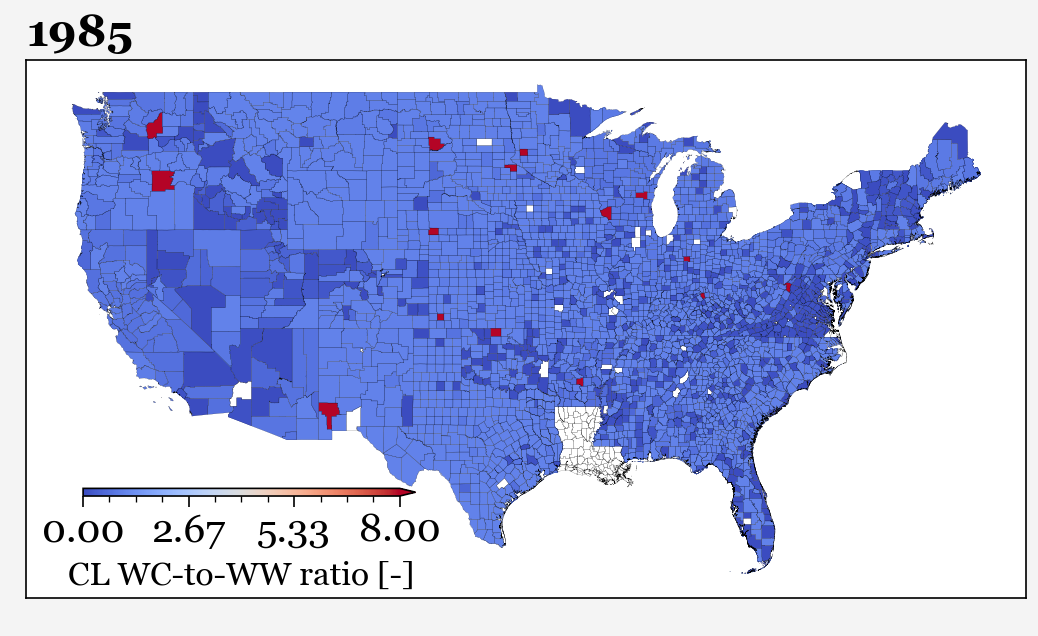

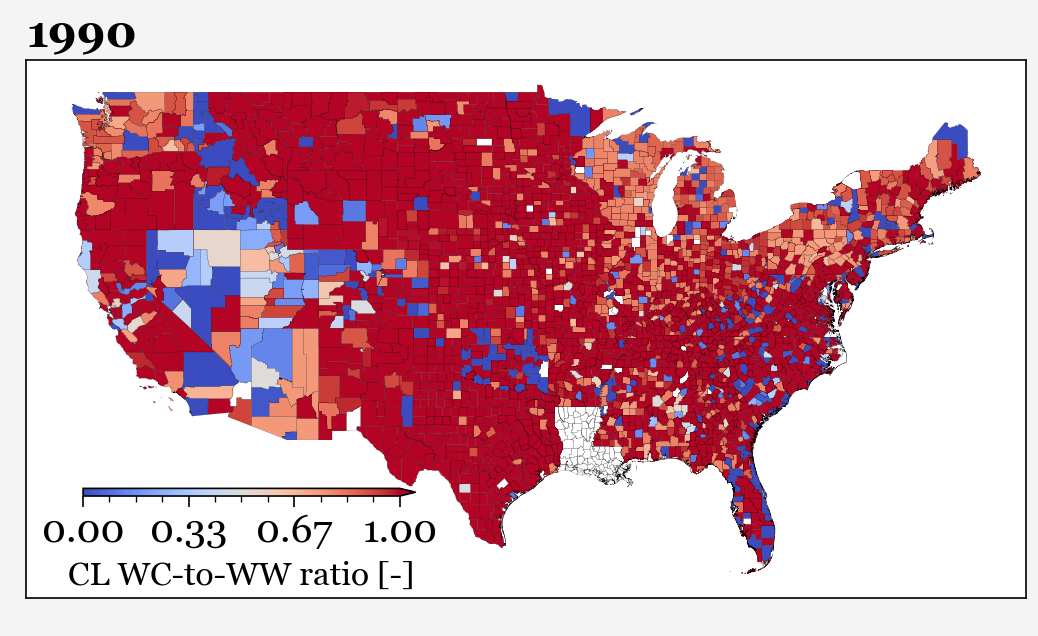

In [ ]:
# plt.rcParams['font.family'] = 'Georgia'

# years_to_plot = [1985, 1990, 1995, 2005, 2010, 2015]
# col_to_plot = 'CL_cons_ratio'
# # title_name = 'b) Beef Cattle'

# for year_to_filter in years_to_plot:
#     # Filter by year
#     merged_gdf = County_Level_Dairy_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW[
#         County_Level_Dairy_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['Year'] == year_to_filter
#     ].copy()

#     # Ensure GeoDataFrame with geometry
#     merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')
    
#     # Align CRS with CONUS counties
#     merged_gdf = merged_gdf.set_crs(CONUS_counties.crs)

#     fig, ax = pplt.subplots(refwidth=5, facecolor="w")#, dpi=200)

#     # Plot polygons
#     merged_gdf.plot(
#         ax=ax,
#         column=col_to_plot,
#         cmap="coolwarm",
#         legend=False
#     )

#     # Overlay county boundaries
#     CONUS_counties.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)

#     # Colorbar
#     vmin, vmax = merged_gdf[col_to_plot].min(), merged_gdf[col_to_plot].max()
#     sm = mpl.cm.ScalarMappable(cmap="coolwarm", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
#     sm._A = []
#     ticks = np.linspace(vmin, vmax, 4)
#     cbar_ax = fig.add_axes([0.08, 0.23, 0.32, 0.012])
#     cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='max', ticks=ticks)
#     cbar.set_label(f"ratio [-]", fontsize=12)
#     cbar.ax.tick_params(labelsize=8)
#     cbar.ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=10)

#     # Title
#     # ax.set_title(fontsize=12, fontweight='bold', loc='left')

#     # Keep border but remove lat/lon ticks and labels
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xlabel('')
#     ax.set_ylabel('')

#     # Keep rectangular border
#     for spine in ax.spines.values():
#         spine.set_visible(True)

#     plt.show()

plt.rcParams['font.family'] = 'Georgia'

years_to_plot = [1985, 1990, 1995, 2005, 2010, 2015]
col_to_plot = 'CL_cons_ratio'

for year_to_filter in years_to_plot:
    # Filter by year
    merged_gdf = County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW[
        County_Level_Beef_Cattle_WC_WW_1985_2022_geo_USGS_WC_WW['Year'] == year_to_filter
    ].copy()

    # Ensure GeoDataFrame with geometry
    merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')
    
    # Align CRS with CONUS counties
    merged_gdf = merged_gdf.set_crs(CONUS_counties.crs)

    fig, ax = pplt.subplots(refwidth=5, facecolor="w")  # , dpi=200

    # Plot polygons
    merged_gdf.plot(
        ax=ax,
        column=col_to_plot,
        cmap="coolwarm",
        legend=False
    )

    # Overlay county boundaries
    CONUS_counties.boundary.plot(ax=ax, edgecolor='black', linewidth=0.05)

    # Colorbar
    vmin, vmax = merged_gdf[col_to_plot].min(), merged_gdf[col_to_plot].max()
    sm = mpl.cm.ScalarMappable(cmap="coolwarm", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    ticks = np.linspace(vmin, vmax, 4)
    cbar_ax = fig.add_axes([0.08, 0.22, 0.32, 0.012])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='max', ticks=ticks)
    cbar.set_label(f"CL WC-to-WW ratio [-]", fontsize=12)
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=14)

    # Title: add corresponding year
    ax.set_title(f"{year_to_filter}", fontsize=16, fontweight='bold', loc='left')

    # Keep border but remove lat/lon ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Keep rectangular border
    for spine in ax.spines.values():
        spine.set_visible(True)

    plt.show()



####################################### Long_term USGS WC-to-WW Ratios ###################################################

plt.rcParams['font.family'] = 'Georgia'
col_to_plot = 'CL_cons_ratio'

# --- Compute long-term mean (1985–2022) ---
mean_gdf = (
    County_Level_Beef_Cattle_WC_WW_1985_2022_geo
    .groupby('COUNTY_NAME', as_index=False)[col_to_plot]
    .mean()
)

# Merge mean values with geometry
merged_mean_gdf = CONUS_counties.merge(mean_gdf, on='COUNTY_NAME', how='left')

# Ensure GeoDataFrame and matching CRS
merged_mean_gdf = gpd.GeoDataFrame(merged_mean_gdf, geometry='geometry')
merged_mean_gdf = merged_mean_gdf.set_crs(CONUS_counties.crs)

# --- Plot ---
fig, ax = pplt.subplots(refwidth=5, facecolor="w", dpi=200)

# Plot polygons
merged_mean_gdf.plot(
    ax=ax,
    column=col_to_plot,
    cmap="jet",
    legend=False
)

# Overlay county boundaries
CONUS_counties.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.03)
# states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.3)

# Colorbar
vmin, vmax = merged_mean_gdf[col_to_plot].min(), merged_mean_gdf[col_to_plot].max()
sm = mpl.cm.ScalarMappable(cmap="jet", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
ticks = np.linspace(vmin, vmax, 4)
cbar_ax = fig.add_axes([0.08, 0.22, 0.32, 0.012])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='max', ticks=ticks)
cbar.set_label(f"CL WC-to-WW ratio [-]", fontsize=12)
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=8)
ax.set_title(f"LOngTerm mean WC-to-WW ratio", fontsize=16, fontweight='bold', loc='left')
# Clean axes
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(''); ax.set_ylabel('')
# for spine in ax.spines.values():
#     spine.set_visible(True)

plt.tight_layout()
# fig.savefig("beef_Wccs_adjusted_1985_2022.png", dpi=600, bbox_inches='tight')

plt.show()



# LongTerm Aveeages:

C:\Users\hdagne1\AppData\Local\Temp\ipykernel_29600\1562864627.py:50: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  plt.tight_layout()


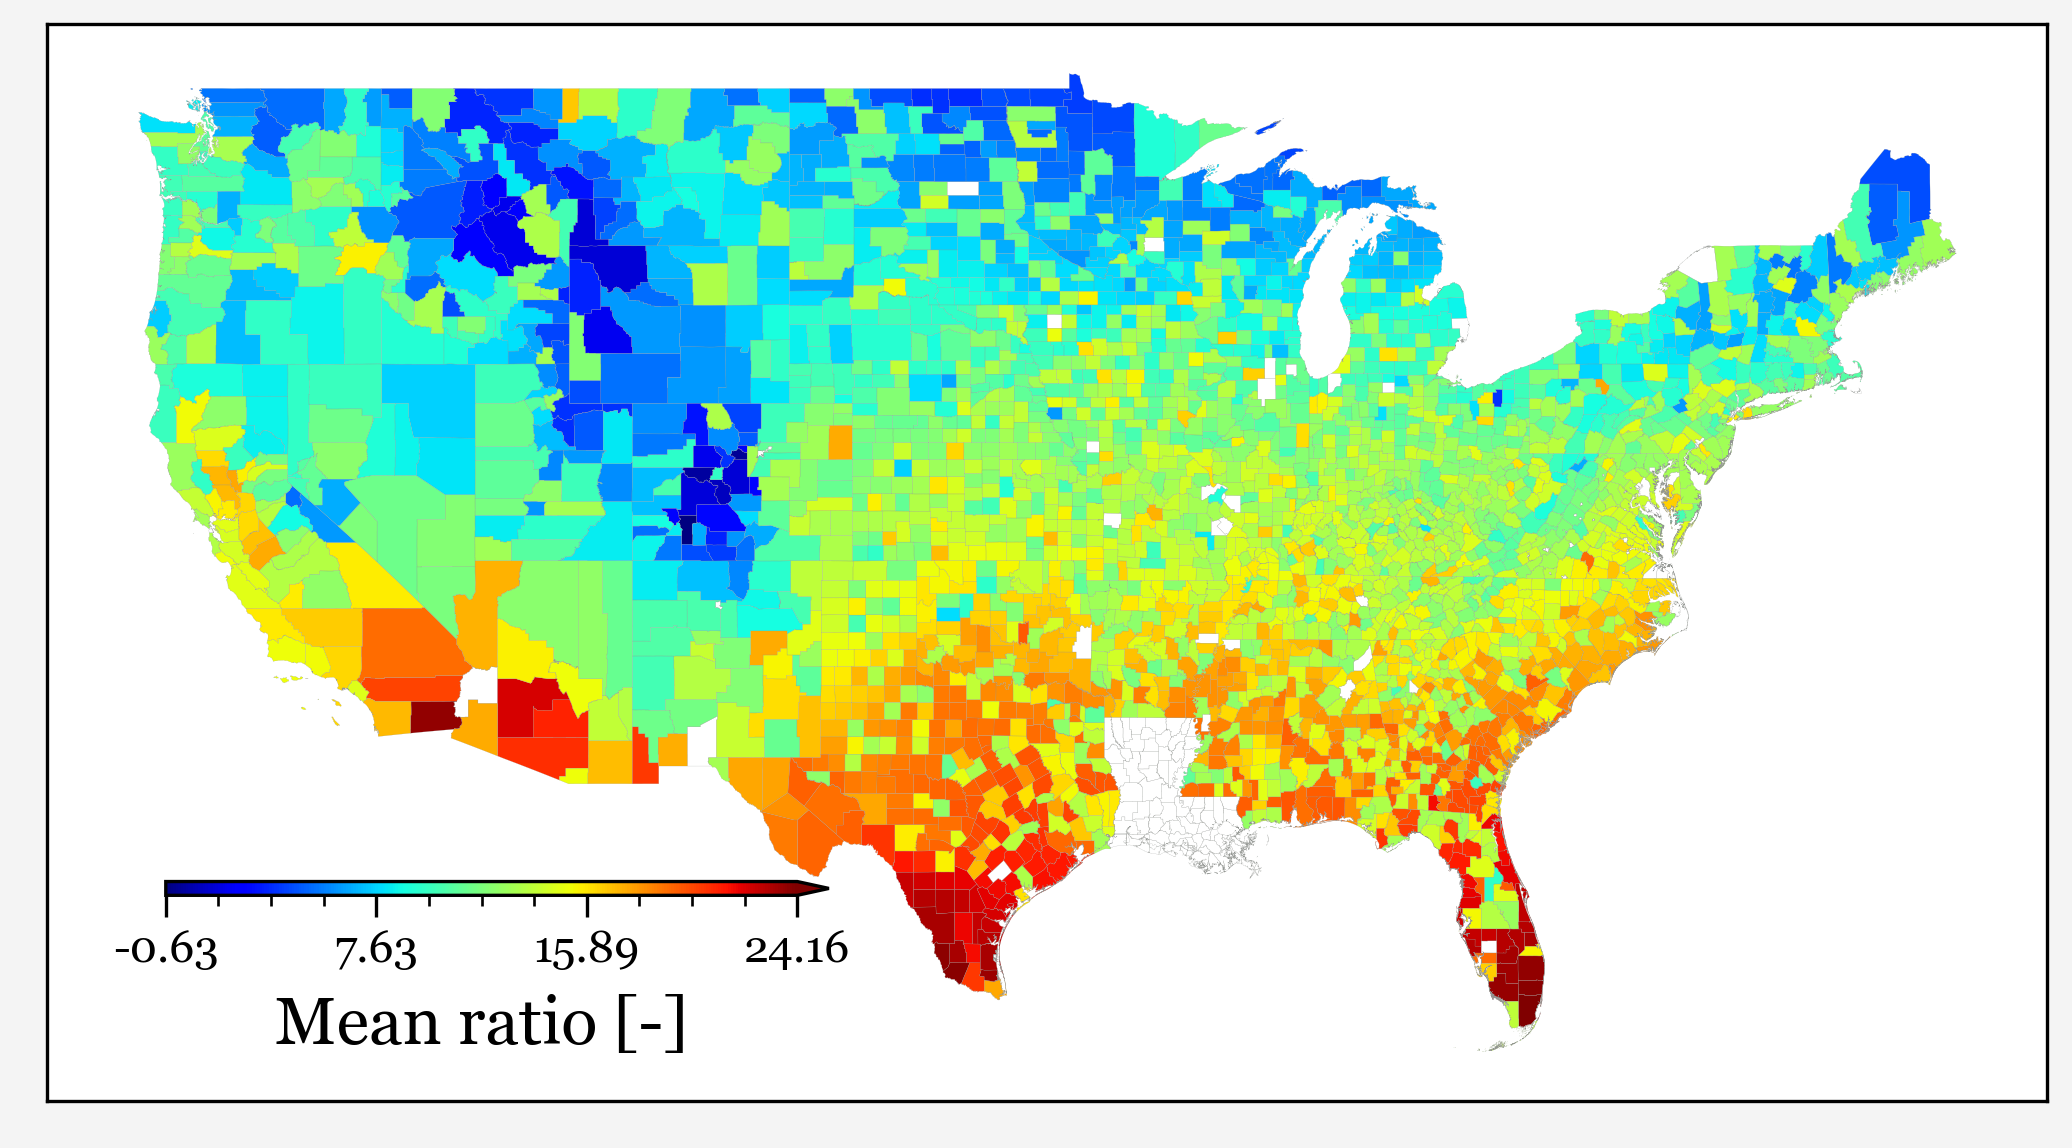

In [211]:
plt.rcParams['font.family'] = 'Georgia'
col_to_plot = 'temp_county'

# --- Compute long-term mean (1985–2022) ---
mean_gdf = (
    County_Level_Beef_Cattle_WC_WW_1985_2022_geo
    .groupby('COUNTY_NAME', as_index=False)[col_to_plot]
    .mean()
)

# Merge mean values with geometry
merged_mean_gdf = CONUS_counties.merge(mean_gdf, on='COUNTY_NAME', how='left')

# Ensure GeoDataFrame and matching CRS
merged_mean_gdf = gpd.GeoDataFrame(merged_mean_gdf, geometry='geometry')
merged_mean_gdf = merged_mean_gdf.set_crs(CONUS_counties.crs)

# --- Plot ---
fig, ax = pplt.subplots(refwidth=5, facecolor="w", dpi=200)

# Plot polygons
merged_mean_gdf.plot(
    ax=ax,
    column=col_to_plot,
    cmap="jet",
    legend=False
)

# Overlay county boundaries
CONUS_counties.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.03)
# states.boundary.plot(ax=ax, edgecolor='black', linewidth=0.3)

# Colorbar
vmin, vmax = merged_mean_gdf[col_to_plot].min(), merged_mean_gdf[col_to_plot].max()
sm = mpl.cm.ScalarMappable(cmap="jet", norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
ticks = np.linspace(vmin, vmax, 4)
cbar_ax = fig.add_axes([0.08, 0.22, 0.32, 0.012])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', extend='max', ticks=ticks)
cbar.set_label(f"Mean ratio [-]", fontsize=12)
cbar.ax.tick_params(labelsize=6)
cbar.ax.set_xticklabels([f"{t:.2f}" for t in ticks], fontsize=8)

# Clean axes
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(''); ax.set_ylabel('')
# for spine in ax.spines.values():
#     spine.set_visible(True)

plt.tight_layout()
# fig.savefig("beef_Wccs_adjusted_1985_2022.png", dpi=600, bbox_inches='tight')

plt.show()

